# Introduction to Spark

## Basic initialization

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [3]:
!pip install -q findspark
!pip install https://github.com/matplotlib/basemap/archive/master.zip

     - 133.1 MB 113.9 MB/s
     |████████████████████████████████| 6.3 MB 12.6 MB/s 
     |████████████████████████████████| 219 kB 68.3 MB/s 
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759592 sha256=e5020bde4d15284d4340f0f982ad8e96a3bf419d8ad85f01a63ac4435f384ad6
  Stored in directory: /tmp/pip-ephem-wheel-cache-7vphis8n/wheels/98/1a/9d/de6aa4dee52d726996be77bb4a65cf03865288bfc35e5b24d8
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37325 sha256=7f5b52e17cc41c7b69d77f23f62dbf464dc92126447296ff9a667368b34d33b0
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built basemap pyshp


In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [5]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [6]:
sc = spark.sparkContext

`SparkSession` is used to connect to the Spark Cluster.

In [7]:
from pyspark.sql import SparkSession

We will use Pandas to operate on the reduced data in the *driver program*.

In [8]:
import pandas as pd

Numpy will be always useful.

In [9]:
import numpy as np

Create a new session (or reuse an existing one).

In [10]:
spark = SparkSession.builder.getOrCreate()

In [11]:
spark

We can see that the session is established.

## Creating Spark Data Frames from Pandas

We can list the tables in our Spark Session, currently empty.

In [12]:
print(spark.catalog.listTables())

[]


We can create a Pandas `DataFrame` with random values.

In [13]:
pd_temp = pd.DataFrame(np.random.random(100))

We can see on the plot that it is really random:

In [14]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

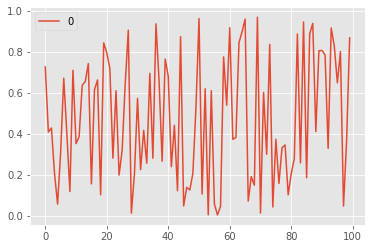

In [15]:
pd_temp.plot()

Now we can convert it into Spark DataFrame:

In [16]:
spark_temp = spark.createDataFrame(pd_temp)

`createOrReplaceTempView` creates (or replaces if that view name already exists) a lazily evaluated "view" that you can then use like a table in Spark SQL. 

It does not persist to memory unless you cache (persist) the dataset that underpins the view.

In [17]:
spark_temp.createOrReplaceTempView("temp")

The created view is `TEMPORARY` which means it is not persistent.

In [18]:
print(spark.catalog.listTables())

[Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


In [19]:
spark_temp.show()

+-------------------+
|                  0|
+-------------------+
| 0.7250684186658413|
| 0.4080447317505179|
| 0.4278460758217374|
|0.20639110311862918|
| 0.0565544376203716|
|0.31155090999975266|
| 0.6705728941046881|
| 0.4040176387834825|
|0.11798345660915366|
| 0.7089870480441443|
| 0.3515551299602625|
| 0.3847675698818067|
| 0.6356731450624051|
| 0.6539514889993032|
| 0.7418318237086909|
|0.15511365921111253|
| 0.6143327022610134|
| 0.6620133368076119|
| 0.1023356850282473|
| 0.8424342780509355|
+-------------------+
only showing top 20 rows



We can now use transformations on this DataFrame. The transformations are translated (compiled) to RDD transformations.

In [20]:
from pyspark.sql.functions import col, asc

In [21]:
spark_temp.filter((col('0') > 0.9)).show()

+------------------+
|                 0|
+------------------+
|0.9044819109350353|
|0.9354446713733876|
|0.9612661266827213|
|0.9165776115522918|
| 0.958335719186053|
| 0.967443691048672|
| 0.944193926274769|
|0.9376205583387947|
|  0.91536861797993|
+------------------+



## Creating Spark Data Frames from input files

In [22]:
from google.colab import drive
drive.mount('/content/drive/')

google_drive_path = 'drive/MyDrive/Colab Notebooks/Data/'

Mounted at /content/drive/


In [23]:
!ls
file_path = google_drive_path + "airports.csv"

# Read in the airports data
airports = spark.read.csv(file_path,header=True)

# Show the data
print(airports.show())

drive	     spark-3.0.0-bin-hadoop3.2	    spark-warehouse
sample_data  spark-3.0.0-bin-hadoop3.2.tgz
+---+--------------------+------------------+----------------+---+----+------------------+-------------------+----+---+---+--------------------+-------+-----------+
|  1|      Goroka Airport|            Goroka|Papua New Guinea|GKA|AYGA|-6.081689834590001|      145.391998291|5282| 10|  U|Pacific/Port_Moresby|airport|OurAirports|
+---+--------------------+------------------+----------------+---+----+------------------+-------------------+----+---+---+--------------------+-------+-----------+
|  2|      Madang Airport|            Madang|Papua New Guinea|MAG|AYMD|    -5.20707988739|      145.789001465|  20| 10|  U|Pacific/Port_Moresby|airport|OurAirports|
|  3|Mount Hagen Kagam...|       Mount Hagen|Papua New Guinea|HGU|AYMH|-5.826789855957031| 144.29600524902344|5388| 10|  U|Pacific/Port_Moresby|airport|OurAirports|
|  4|      Nadzab Airport|            Nadzab|Papua New Guinea|LAE|AYNZ|    

It may be useful to convert them to Pandas for quick browsing. 

**Warning!** This is not efficient for large datasets, as it requires performing actions on the dataset.

In [24]:
airports.toPandas()

,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081689834590001,145.391998291,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
0,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20707988739,145.789001465,20,10,U,Pacific/Port_Moresby,airport,OurAirports
1,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826789855957031,144.29600524902344,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
2,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
3,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380355834961,147.22000122070312,146,10,U,Pacific/Port_Moresby,airport,OurAirports
4,6,Wewak International Airport,Wewak,Papua New Guinea,WWK,AYWK,-3.58383011818,143.669006348,19,10,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7178,12053,Rugao Air Base,Rugao,China,RUG,ZSRG,32.25788497924805,120.50165557861328,0,\N,\N,\N,airport,OurAirports
7179,12054,Wuhu Air Base,Wuhu,China,WHU,ZSWU,31.3906,118.408997,0,\N,\N,\N,airport,OurAirports
7180,12055,Shanshan Airport,Shanshan,China,SXJ,ZWSS,42.91170120239258,90.24749755859375,0,\N,\N,\N,airport,OurAirports
7181,12056,Yingkou Lanqi Airport,Yingkou,China,YKH,ZYYK,40.542524,122.3586,0,\N,\N,\N,airport,OurAirports


### Running SQL queries on dataframes

In [25]:
airports.createOrReplaceTempView("airports")

In [26]:
# Get the first 10 rows of flights
query = "FROM airports SELECT * LIMIT 10"

airports10 = spark.sql(query)

# Show the results
airports10.show()

+---+--------------------+------------+----------------+---+----+------------------+------------------+----+---+---+--------------------+-------+-----------+
|  1|      Goroka Airport|      Goroka|Papua New Guinea|GKA|AYGA|-6.081689834590001|     145.391998291|5282| 10|  U|Pacific/Port_Moresby|airport|OurAirports|
+---+--------------------+------------+----------------+---+----+------------------+------------------+----+---+---+--------------------+-------+-----------+
|  2|      Madang Airport|      Madang|Papua New Guinea|MAG|AYMD|    -5.20707988739|     145.789001465|  20| 10|  U|Pacific/Port_Moresby|airport|OurAirports|
|  3|Mount Hagen Kagam...| Mount Hagen|Papua New Guinea|HGU|AYMH|-5.826789855957031|144.29600524902344|5388| 10|  U|Pacific/Port_Moresby|airport|OurAirports|
|  4|      Nadzab Airport|      Nadzab|Papua New Guinea|LAE|AYNZ|         -6.569803|        146.725977| 239| 10|  U|Pacific/Port_Moresby|airport|OurAirports|
|  5|Port Moresby Jack...|Port Moresby|Papua New Gui

### More complex examples 

Read data from CSV file:
 * `inferSchema` - to detect which columns are numbers (not strigs!) - useful e.g. for sorting.
 * `header` - to read the firs line as column names

In [29]:
countries = spark.read.csv(google_drive_path + "countries of the world.csv",inferSchema=True,header=True)

In [30]:
countries.toPandas()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",None,None,None
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,"419,9","0,00","2,98","19,62",800.0,None,"145,2","16,9","18,97","64,13",3,"31,67","3,92","0,09","0,28","0,63"
223,Western Sahara,NORTHERN AFRICA,273008,266000,"1,0","0,42",None,None,NaN,None,None,"0,02",0,"99,98",1,None,None,None,None,"0,4"
224,Yemen,NEAR EAST,21456188,527970,"40,6","0,36",0,"61,5",800.0,"50,2","37,2","2,78","0,24","96,98",1,"42,89","8,3","0,135","0,472","0,393"
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,"15,3","0,00",0,"88,29",800.0,"80,6","8,2","7,08","0,03","92,9",2,41,"19,93","0,22","0,29","0,489"


We can inspect the schema of the DataFrame.

In [31]:
countries.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Population: integer (nullable = true)
 |-- Area (sq. mi.): integer (nullable = true)
 |-- Pop. Density (per sq. mi.): string (nullable = true)
 |-- Coastline (coast/area ratio): string (nullable = true)
 |-- Net migration: string (nullable = true)
 |-- Infant mortality (per 1000 births): string (nullable = true)
 |-- GDP ($ per capita): integer (nullable = true)
 |-- Literacy (%): string (nullable = true)
 |-- Phones (per 1000): string (nullable = true)
 |-- Arable (%): string (nullable = true)
 |-- Crops (%): string (nullable = true)
 |-- Other (%): string (nullable = true)
 |-- Climate: string (nullable = true)
 |-- Birthrate: string (nullable = true)
 |-- Deathrate: string (nullable = true)
 |-- Agriculture: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Service: string (nullable = true)



### Examples of SQL Queries

In [32]:
countries.createOrReplaceTempView("countries")

In [33]:
spark.sql("SELECT * FROM countries WHERE Region LIKE '%OCEANIA%'").toPandas()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000,"97,0","259,5",10,15,75,2,"22,46","3,27",None,None,None
1,Australia,OCEANIA,20264082,7686850,"2,6","0,34","3,98","4,69",29000,"100,0","565,5","6,55","0,04","93,41",1,"12,14","7,51","0,038","0,262","0,7"
2,Cook Islands,OCEANIA,21388,240,"89,1","50,00",None,None,5000,"95,0","289,9","17,39","13,04","69,57",2,21,None,"0,151","0,096","0,753"
3,Fiji,OCEANIA,905949,18270,"49,6","6,18","-3,14","12,62",5800,"93,7","112,6","10,95","4,65","84,4",2,"22,55","5,65","0,089","0,135","0,776"
4,French Polynesia,OCEANIA,274578,4167,"65,9","60,60","2,94","8,44",17500,"98,0","194,5","0,82","5,46","93,72",2,"16,68","4,69","0,031","0,19","0,769"
5,Guam,OCEANIA,171019,541,"316,1","23,20",0,"6,94",21000,"99,0","492,0","9,09","16,36","74,55",2,"18,79","4,48",None,None,None
6,Kiribati,OCEANIA,105432,811,"130,0","140,94",0,"48,52",800,None,"42,7","2,74","50,68","46,58",2,"30,65","8,26","0,089","0,242","0,668"
7,Marshall Islands,OCEANIA,60422,11854,"5,1","3,12","-6,04","29,45",1600,"93,7","91,2","16,67","38,89","44,44",2,"33,05","4,78","0,317","0,149","0,534"
8,"Micronesia, Fed. St.",OCEANIA,108004,702,"153,9","870,66","-20,99","30,21",2000,"89,0","114,8","5,71","45,71","48,58",2,"24,68","4,75","0,289","0,152","0,559"
9,Nauru,OCEANIA,13287,21,"632,7","142,86",0,"9,95",5000,None,"143,0",0,0,100,2,"24,76","6,7",None,None,None


### Queries using PySpark DSL

DSL = Domain Specific Language - API similar to natural or other language, implemented as library in another language.

List all the countries with the population > 38 million

In [34]:
countries.filter((col("Population") > 38000000)).orderBy("Population").toPandas()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Poland,EASTERN EUROPE,38536869,312685,"123,3","0,16","-0,49","8,51",11100,"99,8","306,3","45,91","1,12","52,97",3,"9,85","9,89","0,05","0,311","0,64"
1,Argentina,LATIN AMER. & CARIB,39921833,2766890,"14,4","0,18","0,61","15,18",11200,"97,1","220,4","12,31","0,48","87,21",3,"16,73","7,55","0,095","0,358","0,547"
2,Spain,WESTERN EUROPE,40397842,504782,"80,0","0,98","0,99","4,42",22000,"97,9","453,5","26,07","9,87","64,06",3,"10,06","9,72","0,04","0,295","0,665"
3,Sudan,SUB-SAHARAN AFRICA,41236378,2505810,"16,5","0,03","-0,02","62,5",1900,"61,1","16,3","6,83","0,18","92,99",2,"34,53","8,97","0,387","0,203","0,41"
4,Colombia,LATIN AMER. & CARIB,43593035,1138910,"38,3","0,28","-0,31","20,97",6300,"92,5","176,2","2,42","1,67","95,91",2,"20,48","5,58","0,125","0,342","0,533"
5,South Africa,SUB-SAHARAN AFRICA,44187637,1219912,"36,2","0,23","-0,29","61,81",10700,"86,4","107,0","12,08","0,79","87,13",1,"18,2",22,"0,025","0,303","0,671"
6,Ukraine,C.W. OF IND. STATES,46710816,603700,"77,4","0,46","-0,39","20,34",5400,"99,7","259,9","56,21","1,61","42,18",3,"8,82","14,39","0,187","0,452","0,361"
7,Burma,ASIA (EX. NEAR EAST),47382633,678500,"69,8","0,28","-1,8","67,24",1800,"85,3","10,1","15,19","0,97","83,84",2,"17,91","9,83","0,564","0,082","0,353"
8,"Korea, South",ASIA (EX. NEAR EAST),48846823,98480,"496,0","2,45",0,"7,05",17800,"97,9","486,1","17,18","1,95","80,87",3,10,"5,85","0,033","0,403","0,563"
9,Italy,WESTERN EUROPE,58133509,301230,"193,0","2,52","2,07","5,94",26700,"98,6","430,9","27,79","9,53","62,68",None,"8,72","10,4","0,021","0,291","0,688"


Select all the countries from Europe

In [35]:
countries.select("Country", "Population").where(col("Region").like("%EUROPE%")).show()

+--------------------+----------+
|             Country|Population|
+--------------------+----------+
|            Albania |   3581655|
|            Andorra |     71201|
|            Austria |   8192880|
|            Belgium |  10379067|
|Bosnia & Herzegov...|   4498976|
|           Bulgaria |   7385367|
|            Croatia |   4494749|
|     Czech Republic |  10235455|
|            Denmark |   5450661|
|      Faroe Islands |     47246|
|            Finland |   5231372|
|             France |  60876136|
|            Germany |  82422299|
|          Gibraltar |     27928|
|             Greece |  10688058|
|           Guernsey |     65409|
|            Hungary |   9981334|
|            Iceland |    299388|
|            Ireland |   4062235|
|        Isle of Man |     75441|
+--------------------+----------+
only showing top 20 rows



Conditions in `where` clause can contain logical expressions.

In [36]:
countries.select("Country", "Population")\
.where((col("Region").like("%EUROPE%")) & (col("Population")> 10000000)).show()

+---------------+----------+
|        Country|Population|
+---------------+----------+
|       Belgium |  10379067|
|Czech Republic |  10235455|
|        France |  60876136|
|       Germany |  82422299|
|        Greece |  10688058|
|         Italy |  58133509|
|   Netherlands |  16491461|
|        Poland |  38536869|
|      Portugal |  10605870|
|       Romania |  22303552|
|         Spain |  40397842|
|United Kingdom |  60609153|
+---------------+----------+



### Aggregation

We can run aggregations with predefined functions (faster!):

In [37]:
from pyspark.sql.functions import sum

In [38]:
pd_countries = countries.select("Region", "Population").groupBy("Region").agg(sum("Population")).toPandas()

In [39]:
pd_countries

,Region,sum(Population)
0,BALTICS,7184974
1,C.W. OF IND. STATES,280081548
2,ASIA (EX. NEAR EAST),3687982236
3,WESTERN EUROPE,396339998
4,NORTHERN AMERICA,331672307
5,NEAR EAST,195068377
6,EASTERN EUROPE,119914717
7,OCEANIA,33131662
8,SUB-SAHARAN AFRICA,749437000
9,NORTHERN AFRICA,161407133


We can make the column name look better, by using `alias`:

In [40]:
pd_countries = countries.select("Region", "Population").groupBy("Region").agg(sum("Population").alias('Total')).toPandas()

In [41]:
pd_countries

,Region,Total
0,BALTICS,7184974
1,C.W. OF IND. STATES,280081548
2,ASIA (EX. NEAR EAST),3687982236
3,WESTERN EUROPE,396339998
4,NORTHERN AMERICA,331672307
5,NEAR EAST,195068377
6,EASTERN EUROPE,119914717
7,OCEANIA,33131662
8,SUB-SAHARAN AFRICA,749437000
9,NORTHERN AFRICA,161407133


### Plot examples 
Pandas DataFrames are useful for plotting using MatPlotLib:

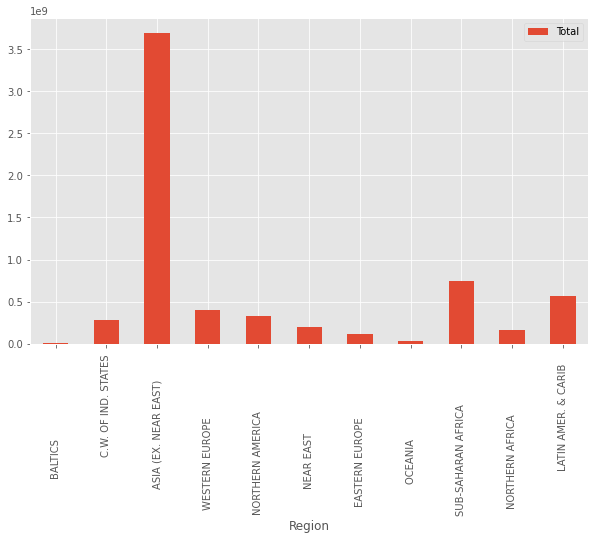

In [42]:
pd_countries.plot(x='Region', y='Total',kind='bar', figsize=(10, 6))

## User defined functions for data manipulation
Our `countries` DataFrame has some problems:
 * missing values
 * some numbers use comma instead of point as floating point separator (e.g. Literacy  = 99,4)
 
We can clean the data using User Defined Functions (UDF)

In [43]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

Define a Python function which coverts numbers with commas to `float`

In [44]:
def to_float (s) :
   return float(s.replace(',','.'))

Test that it works:

In [45]:
to_float('0,99')

0.99

Now define a Spark UDF:

In [46]:
float_udf = udf(to_float , FloatType())

Test it on a Data Frame

In [47]:
countries.withColumn("Literacy", float_udf("Literacy (%)"))

DataFrame[Country: string, Region: string, Population: int, Area (sq. mi.): int, Pop. Density (per sq. mi.): string, Coastline (coast/area ratio): string, Net migration: string, Infant mortality (per 1000 births): string, GDP ($ per capita): int, Literacy (%): string, Phones (per 1000): string, Arable (%): string, Crops (%): string, Other (%): string, Climate: string, Birthrate: string, Deathrate: string, Agriculture: string, Industry: string, Service: string, Literacy: float]

OK, we can see that the `Literacy` is now `float`

In [48]:
countries.show(50)

+--------------------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|             Country|              Region|Population|Area (sq. mi.)|Pop. Density (per sq. mi.)|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service|
+--------------------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+
|        Afghanistan |ASIA (EX. NEAR EA...|  31056997|       

In [49]:
countries.where((col("Literacy") < 50) & (col("GDP ($ per capita)") > 700)).show()

AnalysisException: ignored

Oops, what does it mean???

- some rows have empty values!

Before we can use the table, we need to remove empty rows. Otherwise our UDF will fail.

In [51]:
full_countries = countries.select('Country', 'Population', 'Literacy (%)', 'GDP ($ per capita)').na.drop()

We can now apply the new UDF to the Data Frame:

In [52]:
full_countries = full_countries.withColumn("Literacy", float_udf("Literacy (%)"))

In [53]:
full_countries.show(50)

+--------------------+----------+------------+------------------+--------+
|             Country|Population|Literacy (%)|GDP ($ per capita)|Literacy|
+--------------------+----------+------------+------------------+--------+
|        Afghanistan |  31056997|        36,0|               700|    36.0|
|            Albania |   3581655|        86,5|              4500|    86.5|
|            Algeria |  32930091|        70,0|              6000|    70.0|
|     American Samoa |     57794|        97,0|              8000|    97.0|
|            Andorra |     71201|       100,0|             19000|   100.0|
|             Angola |  12127071|        42,0|              1900|    42.0|
|           Anguilla |     13477|        95,0|              8600|    95.0|
|  Antigua & Barbuda |     69108|        89,0|             11000|    89.0|
|          Argentina |  39921833|        97,1|             11200|    97.1|
|            Armenia |   2976372|        98,6|              3500|    98.6|
|              Aruba |   

In [54]:
full_countries.where((col("Literacy") < 50) & (col("GDP ($ per capita)") > 700)).show()

+--------------+----------+------------+------------------+--------+
|       Country|Population|Literacy (%)|GDP ($ per capita)|Literacy|
+--------------+----------+------------+------------------+--------+
|       Angola |  12127071|        42,0|              1900|    42.0|
|   Bangladesh | 147365352|        43,1|              1900|    43.1|
|        Benin |   7862944|        40,9|              1100|    40.9|
|       Bhutan |   2279723|        42,2|              1300|    42.2|
| Burkina Faso |  13902972|        26,6|              1100|    26.6|
|         Chad |   9944201|        47,5|              1200|    47.5|
|  Gambia, The |   1641564|        40,1|              1700|    40.1|
|       Guinea |   9690222|        35,9|              2100|    35.9|
|Guinea-Bissau |   1442029|        42,4|               800|    42.4|
|         Iraq |  26783383|        40,4|              1500|    40.4|
|         Mali |  11716829|        46,4|               900|    46.4|
|   Mauritania |   3177388|       

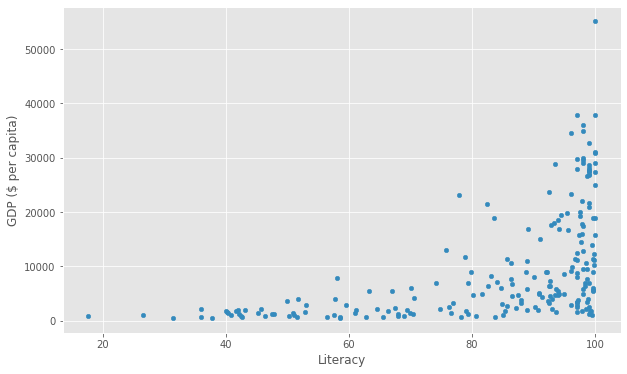

In [55]:
full_countries.toPandas().plot(x="Literacy",y="GDP ($ per capita)",kind="scatter",figsize=(10, 6))

# Useful information

 * https://spark.apache.org/docs/latest/quick-start.html
 * https://spark.apache.org/docs/latest/sql-programming-guide.html
 * https://pandas.pydata.org/pandas-docs/stable/visualization.html

# Zadanie domowe

## Zadanie 1
Narysuj wykres zależności kolumn Plot Infant mortality vs. Literacy dla 30 najbogatszych i 30 najbiedniejszych krajów.

In [56]:
countries_infant_vs_literacy = countries.select("Country","Infant mortality (per 1000 births)","Literacy (%)","GDP ($ per capita)").na.drop()
countries_infant_vs_literacy = countries_infant_vs_literacy.withColumn("Literacy", float_udf("Literacy (%)")).withColumn("Infant mortality", float_udf("Infant mortality (per 1000 births)"))

In [57]:
from pyspark.sql.functions import desc

countries_infant_vs_literacy_best = countries_infant_vs_literacy.orderBy(desc("GDP ($ per capita)")).limit(30)
countries_infant_vs_literacy_worst = countries_infant_vs_literacy.orderBy("GDP ($ per capita)").limit(30)

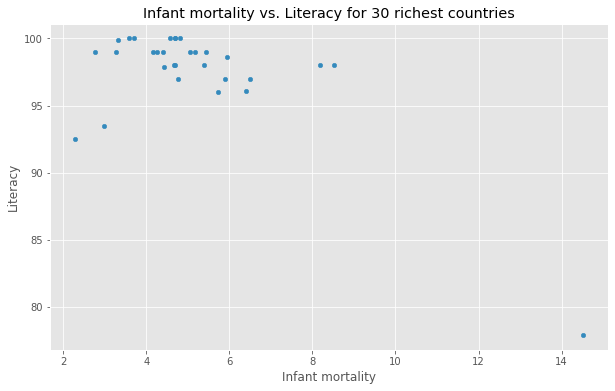

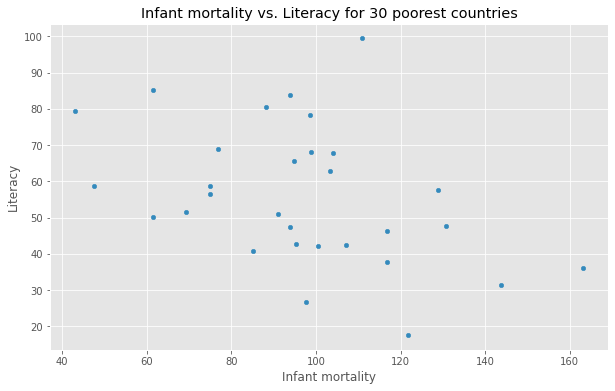

In [58]:
countries_infant_vs_literacy_best.toPandas().plot(x="Infant mortality",y="Literacy",kind="scatter",figsize=(10, 6),title="Infant mortality vs. Literacy for 30 richest countries")
countries_infant_vs_literacy_worst.toPandas().plot(x="Infant mortality",y="Literacy",kind="scatter",figsize=(10, 6),title="Infant mortality vs. Literacy for 30 poorest countries")

## Zadanie 2
Wczytaj zbiór danych "airports.csv" ze strony https://www.kaggle.com/jonatancr/airports (zawiera on dane na temat lotnisk z całego świata). Ponieważ w zbiorze tym nie ma nagłówka, nadaj własne nazwy kolumnom, korzystając z opisu pliku na stronie https://openflights.org/data.html. Narysuj na wykresie (mapie) położenia wszystkich/wybranych lotnisk.1

In [137]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType

file_path = google_drive_path + "airports.csv"

schema = StructType([
    StructField("Airport ID", IntegerType(), True),
    StructField("Name", StringType(), True),
    StructField("City", StringType(), True),
    StructField("Country", StringType(), True),
    StructField("IATA", StringType(), True),
    StructField("ICAO", StringType(), True),
    StructField("Latitude", FloatType(), True),
    StructField("Longitude", FloatType(), True),
    StructField("Altitude", StringType(), True),
    StructField("Timezone", StringType(), True),
    StructField("DST", StringType(), True),
    StructField("Tz database time zone", StringType(), True),
    StructField("Type", StringType(), True),
    StructField("Source", StringType(), True)])

airports = spark.read.csv(file_path,header=False,schema=schema)

airports.show()

+----------+--------------------+--------------+----------------+----+----+---------+----------+--------+--------+---+---------------------+-------+-----------+
|Airport ID|                Name|          City|         Country|IATA|ICAO| Latitude| Longitude|Altitude|Timezone|DST|Tz database time zone|   Type|     Source|
+----------+--------------------+--------------+----------------+----+----+---------+----------+--------+--------+---+---------------------+-------+-----------+
|         1|      Goroka Airport|        Goroka|Papua New Guinea| GKA|AYGA| -6.08169|   145.392|    5282|      10|  U| Pacific/Port_Moresby|airport|OurAirports|
|         2|      Madang Airport|        Madang|Papua New Guinea| MAG|AYMD| -5.20708|   145.789|      20|      10|  U| Pacific/Port_Moresby|airport|OurAirports|
|         3|Mount Hagen Kagam...|   Mount Hagen|Papua New Guinea| HGU|AYMH| -5.82679|   144.296|    5388|      10|  U| Pacific/Port_Moresby|airport|OurAirports|
|         4|      Nadzab Airport| 

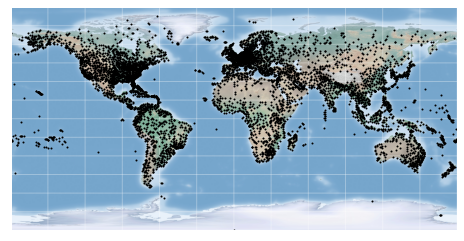

In [60]:
import matplotlib as mlt
from mpl_toolkits.basemap import Basemap
import numpy as np

from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')


fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None )
draw_map(m)

results = airports.select("Latitude", "Longitude")

for airport in results.rdd.collect():
  x, y = airport.Longitude, airport.Latitude
  plt.plot(x, y, 'ok', markersize=1)

## Zadanie 3

Utwórz dwie nowe kolumny w ramce "Countries", w których powierzchnia i gęstość zaludnienia wyrażone sa odpowiednio w milach kwadratowych i osobach na milę kwadratową
Nazwy nowych kolumn proszę ustawić odpowiednio na 'Area (sq mi)' oraz 'Pop Density (per sq mi)'

Uwaga: Typami nowych kolumn mają być odpowiednio integer (powierzchnia) i float (gęstość). Zaokrąglanie do integer: "int(x)"

In [61]:
def to_mile2(x):
  return int(x*0.38613796)

area_udf = udf(to_mile2 , IntegerType())

countries_enriched = countries.withColumn("Area (sq mi)", area_udf("`Area (sq. mi.)`"))
countries_enriched.select("Area (sq mi)","`Area (sq. mi.)`").show()

+------------+--------------+
|Area (sq mi)|Area (sq. mi.)|
+------------+--------------+
|      250024|        647500|
|       11100|         28748|
|      919680|       2381740|
|          76|           199|
|         180|           468|
|      481398|       1246700|
|          39|           102|
|         171|           443|
|     1068401|       2766890|
|       11506|         29800|
|          74|           193|
|     2968184|       7686850|
|       32385|         83870|
|       33439|         86600|
|        5382|         13940|
|         256|           665|
|       55603|        144000|
|         166|           431|
|       80162|        207600|
|       11788|         30528|
+------------+--------------+
only showing top 20 rows



In [62]:
def to_pop_density_mile(x):
  return to_float(x)*2.58974797505

density_udf = udf(to_pop_density_mile , FloatType())

countries_enriched = countries.withColumn("Pop Density (per sq mi)", density_udf("`Pop. Density (per sq. mi.)`"))
countries_enriched.select("Pop Density (per sq mi)","`Pop. Density (per sq. mi.)`").show()

+-----------------------+--------------------------+
|Pop Density (per sq mi)|Pop. Density (per sq. mi.)|
+-----------------------+--------------------------+
|               124.3079|                      48,0|
|               322.6826|                     124,6|
|               35.73852|                      13,8|
|               752.0628|                     290,4|
|              393.90067|                     152,1|
|              25.120556|                       9,7|
|               342.1057|                     132,1|
|              404.00067|                     156,0|
|               37.29237|                      14,4|
|              258.71582|                      99,9|
|               964.6811|                     372,5|
|              6.7333446|                       2,6|
|              253.01837|                      97,7|
|              237.99783|                      91,9|
|              56.456505|                      21,8|
|              2720.5303|                    1

## Zadanie 4
Na wykresie scatterplot narysuj zależność liczby lotnisk od powierzchni kraju.

*   Dane potrzebne do wykresu są w dwóch ramkach (Countries i Airports), konieczne więc będzie ich złączenie (join).
*   Nie zawsze nazwy tych samych krajów będą identyczne w obu ramkach, co może stanowić problem (złączenie nie powstanie). Zastanów się jak przy pomocy mechanizmu złączeń wykryć, które nazwy się różnią. Stwórz odpowiednią ramkę, która zawiera takie nazwy.
*   Następnie zmień nazwy kilku największych państw w jednej z ramek, tak żeby ujednolicić nazwy. Można to zrobić funkcją replace.

In [139]:
import re

def airport_country_name(x):
  x = re.sub('Is(\.|\\b)', 'Islands', x[:-1])
  if x == 'Gaza Strip':
    return 'Palestine'
  if x.startswith('Korea'):
    y = x.split(', ')
    return y[1] + " " + y[0]
  if x.startswith('Congo'):
    if 'Dem' in x:
      return 'Congo (Kinshasa)'
    else:
      return  'Congo (Brazzaville)'  
  return x.replace('&', 'and').replace('Rep.', 'Republic').replace(', The', '').replace('N.', 'Northern').replace('St ', 'Saint ')

countries_names = set(map(lambda x: x.Country, airports.select('Country').distinct().rdd.collect()))
airports_countries = set(map(lambda x: airport_country_name(x.Country), countries.select('Country').distinct().rdd.collect()))
airports_countries - countries_names

{'Andorra', 'Liechtenstein', 'Micronesia, Fed. St.', 'Monaco', 'San Marino'}

In [140]:
country_udf = udf(airport_country_name , StringType())
countries_stand = countries.withColumn('Country_standarized', country_udf('Country'))
countries_stand.select('Country','Country_standarized').show()

+------------------+-------------------+
|           Country|Country_standarized|
+------------------+-------------------+
|      Afghanistan |        Afghanistan|
|          Albania |            Albania|
|          Algeria |            Algeria|
|   American Samoa |     American Samoa|
|          Andorra |            Andorra|
|           Angola |             Angola|
|         Anguilla |           Anguilla|
|Antigua & Barbuda |Antigua and Barbuda|
|        Argentina |          Argentina|
|          Armenia |            Armenia|
|            Aruba |              Aruba|
|        Australia |          Australia|
|          Austria |            Austria|
|       Azerbaijan |         Azerbaijan|
|     Bahamas, The |            Bahamas|
|          Bahrain |            Bahrain|
|       Bangladesh |         Bangladesh|
|         Barbados |           Barbados|
|          Belarus |            Belarus|
|          Belgium |            Belgium|
+------------------+-------------------+
only showing top

In [141]:
countries_airports = airports.join(countries_stand, airports.Country == countries_stand.Country_standarized, 'left')
df = countries_airports.select("Country_standarized","`Area (sq. mi.)`").groupBy("Country_standarized","`Area (sq. mi.)`").count().toPandas()
df.sort_values(by=['count'])

,Country_standarized,Area (sq. mi.),count
104,Saint Helena,413.0,1
99,Barbados,431.0,1
161,Gambia,11300.0,1
136,Swaziland,17363.0,1
21,Mayotte,374.0,1
...,...,...,...
96,Russia,17075200.0,238
160,Germany,357021.0,241
59,Australia,7686850.0,296
16,Canada,9984670.0,417


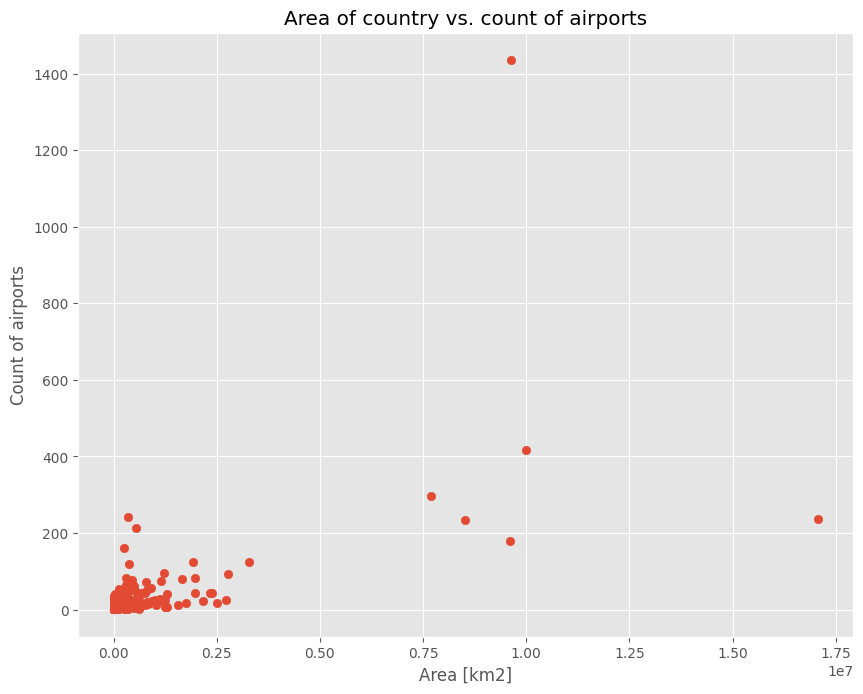

In [142]:
plt.scatter(df['Area (sq. mi.)'], df['count'])
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('Area of country vs. count of airports')
plt.xlabel('Area [km2]')
plt.ylabel('Count of airports')
plt.show()

## Zadanie 5 
Oblicz, ile lotnisk jest na poszczególnych kontynentach. To zadanie również wymaga złączenia ramek "Countries" i "Airports". Wynik przedstaw na wykresie słupkowym.
*      Do ramki "Countries" dodaj nową kolumnę "Continent" (według klasyfikacji Africa, Asia, Europe, North America, South America, Antarctica, Australia/Oceania).
*      Skorzystaj z kolumny "Region" i pomocniczej funkcji (UDF) mapującej region na kontynent.


In [94]:
countries_airports.filter(countries_airports.ICAO == 'NZSP').show()

+----------+--------------------+----------------+----------+----+----+--------+---------+--------+--------+---+---------------------+-------+-----------+-------+------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+-------------------+
|Airport ID|                Name|            City|   Country|IATA|ICAO|Latitude|Longitude|Altitude|Timezone|DST|Tz database time zone|   Type|     Source|Country|Region|Population|Area (sq. mi.)|Pop. Density (per sq. mi.)|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service|Country_standarized|
+----------+--------------------+----------------+----------+----+----+--------+--

In [131]:
from pyspark.sql.functions import lit

def get_continent(region):
  region = region.strip()
  if 'ASIA' in region:
    return 'Asia'
  elif region == 'BALTICS':
    return 'Europe'
  elif 'EUROPE' in region:
    return 'Europe'
  elif 'AFRICA' in region:
    return 'Africa'   
  elif region == 'NORTHERN AMERICA':
    return 'North America'
  elif region == 'C.W. OF IND. STATES':
    return 'Asia'
  elif region == 'NEAR EAST':
    return 'Asia'
  elif region == 'OCEANIA':
    return 'Autralia/Oceania' 
  elif region == 'LATIN AMER. & CARIB':
    return 'South America'       
  elif region == 'ANTARCTICA':
    return 'Antarctica'

continent_udf = udf(get_continent , StringType())    

set(map(lambda x: get_continent(x.Region), countries.select('Region').rdd.collect()))

countries_enriched = countries.union(spark.createDataFrame([['Antarctica ','ANTARCTICA',0,0,'','','','',0,'','','','','','','','','','','']]))
countries_enriched = countries_enriched.withColumn("Continent", continent_udf("Region"))
countries_enriched = countries_enriched.withColumn('Country_standarized', country_udf('Country'))
countries_enriched.filter(countries_enriched.Continent == 'Antarctica').show()

+-----------+----------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+----------+-------------------+
|    Country|    Region|Population|Area (sq. mi.)|Pop. Density (per sq. mi.)|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service| Continent|Country_standarized|
+-----------+----------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+----------+-------------------+
|Antarctica |ANTARCTICA| 

In [132]:
countries_airports = airports.join(countries_enriched, airports.Country == countries_enriched.Country_standarized, 'left')
countries_airports.show()

+----------+--------------------+--------------------+--------+----+----+----------+----------+--------+--------+---+---------------------+-------+-----------+---------+--------------------+----------+--------------+--------------------------+----------------------------+-------------+----------------------------------+------------------+------------+-----------------+----------+---------+---------+-------+---------+---------+-----------+--------+-------+-------------+-------------------+
|Airport ID|                Name|                City| Country|IATA|ICAO|  Latitude| Longitude|Altitude|Timezone|DST|Tz database time zone|   Type|     Source|  Country|              Region|Population|Area (sq. mi.)|Pop. Density (per sq. mi.)|Coastline (coast/area ratio)|Net migration|Infant mortality (per 1000 births)|GDP ($ per capita)|Literacy (%)|Phones (per 1000)|Arable (%)|Crops (%)|Other (%)|Climate|Birthrate|Deathrate|Agriculture|Industry|Service|    Continent|Country_standarized|
+----------+

In [135]:
df = countries_airports.select("Continent").filter(countries_airports.Continent.isNotNull()).groupBy("Continent").count().toPandas().sort_values(by=['count'])
df

,Continent,count
4,Antarctica,7
2,Autralia/Oceania,545
1,Africa,707
5,South America,969
0,Europe,1395
6,Asia,1663
3,North America,1877


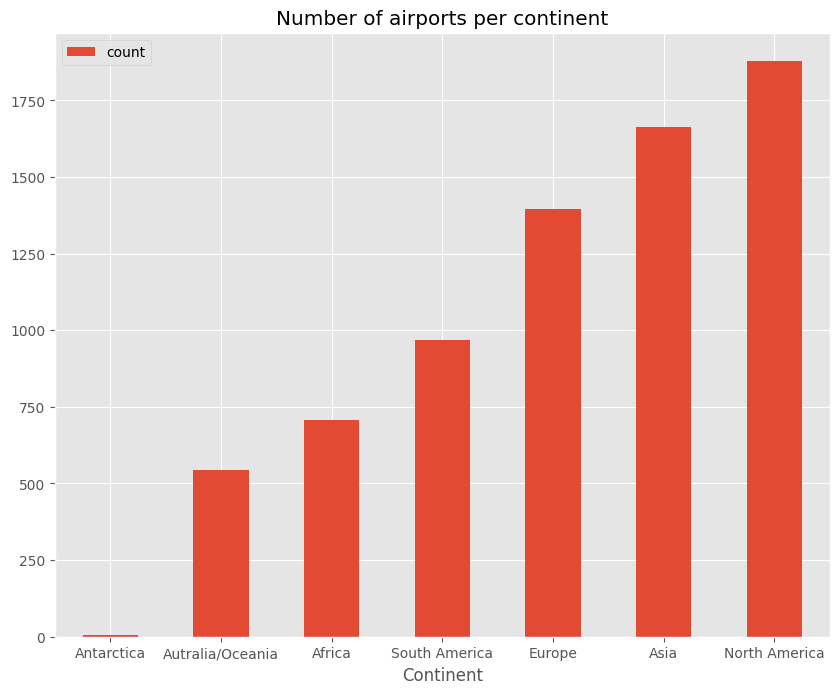

In [136]:
df.plot.bar(x='Continent',y='count',rot=0, title='Number of airports per continent')